In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from abbyy_course_cvdl_t3.coco_text import COCO_Text

In [2]:
base = Path("/home/alexander/Downloads/coco2014/")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'images/train2014'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [3]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.171192
creating index...
index created!


In [4]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation


In [5]:
cd ../task2

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task2


In [32]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.convert import PointsToObjects


In [7]:
cd ../task3

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task3


In [8]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [9]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [10]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [11]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

Quality

In [12]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [14]:
model = torch.load('../task2/centernet.pth')
model.to(torch.device('cpu'));
model.eval();

Text(0.5, 1.0, 'GT: 101243')

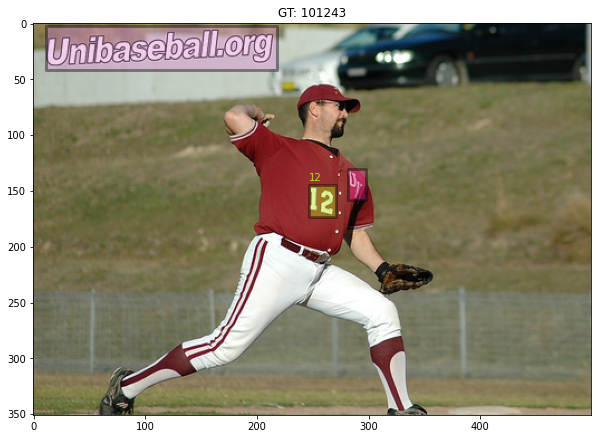

In [15]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")


In [16]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [19]:
preds = model(img[None, :])[0]

In [20]:
import torchvision

In [40]:
prepared_preds = []
img_ids = []
pto = PointsToObjects()

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        pred = model(
            x[None, ...]
        )[0]
        prepared_preds.append(
            pto(pred[None, ...])
        )
        img_ids.append(img_id)


100%|██████████| 4446/4446 [30:12<00:00,  2.45it/s]


In [41]:
prepared_preds[0]

tensor([[[1.0054e+02, 6.9553e+01, 3.0945e+00, 1.2289e+01, 0.0000e+00,
          9.2077e-01],
         [1.0268e+02, 1.0090e+02, 2.4968e+00, 5.5273e+00, 0.0000e+00,
          8.8812e-01],
         [8.5425e+01, 2.8243e+01, 4.2091e+00, 4.8878e+00, 0.0000e+00,
          8.8471e-01],
         [1.0325e+02, 1.0714e+02, 2.1938e+00, 4.9224e+00, 0.0000e+00,
          8.8159e-01],
         [9.9122e+01, 5.5194e+01, 2.8462e+00, 1.3041e+01, 0.0000e+00,
          7.9289e-01],
         [1.0114e+02, 8.3489e+01, 3.1421e+00, 3.2052e+00, 0.0000e+00,
          5.5063e-01],
         [1.0086e+02, 8.3441e+01, 3.3594e+00, 3.2142e+00, 0.0000e+00,
          3.6109e-01],
         [9.8451e+01, 3.2525e+00, 6.6359e+00, 2.3862e+00, 0.0000e+00,
          2.9297e-01],
         [1.2034e+02, 1.0237e+02, 1.7499e+00, 5.1529e+00, 0.0000e+00,
          2.6105e-01],
         [1.2055e+02, 1.0772e+02, 1.7913e+00, 7.0621e+00, 0.0000e+00,
          2.1935e-01],
         [8.5408e+01, 2.7814e+01, 3.8773e+00, 4.9000e+00, 0.0000e+00,


In [70]:
prpr = []
for i in prepared_preds:
    unf = {}
    res = i[i[:, :, -1] > 0.2].detach()
    boxes = res[:, :4].clone()
    b = boxes.clone()
    boxes[:, 2] = (b[:, 2] - b[:, 0])
    boxes[:, 3] = (b[:, 3] - b[:, 1])
    unf['boxes'] = boxes.numpy()
    unf['scores'] = res[:, -1].detach().numpy()
    #print(unf['boxes'].shape[0], unf['scores'].shape[0])
    prpr.append(unf)

Saving

In [71]:
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [72]:
scores = np.concatenate([u['scores'] for u in prpr], axis=0)
boxes = np.concatenate([u['boxes'] for u in prpr], axis=0)

In [73]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prpr[num]['boxes'])
image_ids = np.array(image_ids)

In [74]:
print(len(image_ids.tolist()),
    len(boxes[:, 0].tolist()),
    len(boxes[:, 1].tolist()),
    len(boxes[:, 2].tolist()),
    len(boxes[:, 3].tolist()),
    len(scores.tolist()))

50524 50524 50524 50524 50524 50524


In [75]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

AP

In [76]:
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [77]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")

Loading and preparing results...     
DONE (t=2.96s)
Итоговый скор AP на val: 0.0


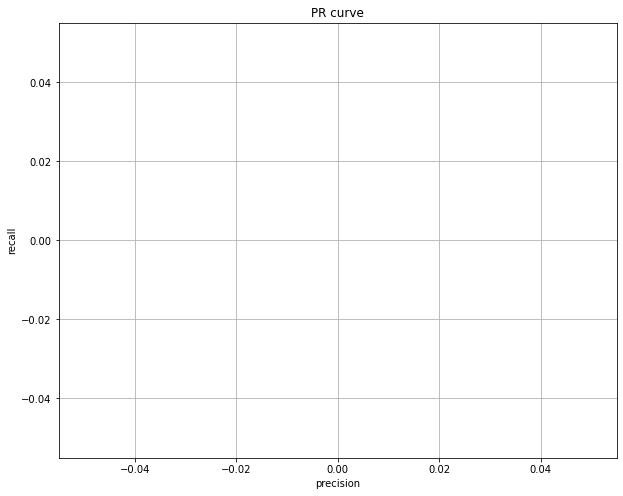

In [78]:
from matplotlib import pyplot as plt
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()